<a id="top"></a>

# Exploring High-Redshift Quasars with eBOSS and JWST
***

## Learning Goals

By the end of this tutorial, you will:

- Understand how to search the MAST Archive and download SDSS eBOSS data using `astroquery.mast`
- Learn how to identify emisison lines in quasar spectra at different redshifts
- Download and plot quasar spectra from both eBOSS and JWST



## Table of Contents
* [Introduction](#introduction)
* [Imports](#imports)
* [Accessing eBOSS data at MAST](#accessing-eboss-data-at-mast)
    * [Querying all eBOSS data](#querying-all-eboss-data)
    * [Searching for a specific target](#searching-for-a-specific-target)
* [Plotting an eBOSS Spectrum](#plotting-an-eboss-spectrum)
    * [Identifying Emission Lines in a QSO Spectrum](#identifying-emission-lines-in-a-qso-spectrum)
    * [Exploring QSO spectra at different redshift](#exploring-qso-spectra-at-different-redshift)
* [Searching for High-Redshift JWST spectra](#searching-for-high-redshift-jwst-spectra)
    * [Combining eBOSS and JWST Data](#combining-eboss-and-jwst-data)
* [Additional Resources](#additional-resources)
    * [How to Cite](#citations)
    * [About This Notebook](#about-this-notebook)


## Introduction
The [Extended Baryonic Oscillaton Spectroscopic Survey (eBOSS)](https://www.sdss4.org/surveys/eboss/) survey provides optical-wavelength 1-D spectra for almost 4,000,000 targets in the northern hemisphere, including stars, galaxies, and quasars. eBOSS collected data between 2008 - 2020 as part of the [Sloan Digital Sky Survey (SDSS-IV) project](https://www.sdss4.org). eBOSS data is now available at the [Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu) through the [SDSS Legacy Archive at MAST](https://archive.stsci.edu/missions-and-data/sdss). 

In this notebook tutorial, we will demonstrate how to access eBOSS data at MAST using Python. One eBOSS target, a quasar named "eBOSS 5733-56575-0260", will be used to demonstrate the basics of how to download and plot eBOSS data. We will then combine this eBOSS spectrum with infrared spectra from JWST, also accessible from MAST, to study quasars at different redshifts.

## Imports

The main packages we're using for this notebook and their use-cases are:
- *astroquery.mast.Observations* for searching the MAST archive
- *astropy.io fits* for accessing FITS files
- *matplotlib* for plotting and displaying data
- *numpy* to handle array functions and basic math

In [1]:
%matplotlib inline

from astroquery.mast import Observations
import astropy.io.fits as fits

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patheffects as path_effects
from matplotlib.patches import ConnectionPatch

import numpy as np

This cell updates some of the settings in `matplotlib` to use larger font sizes in the figures:

In [2]:
#Update Plotting Parameters
params = {'axes.labelsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 
          'text.usetex': False, 'lines.linewidth': 1,
          'axes.titlesize': 18, 'font.family': 'serif', 'font.size': 12}
plt.rcParams.update(params)

***
# Accessing eBOSS data at MAST

The [SDSS Legacy Archive at MAST](https://archive.stsci.edu/missions-and-data/sdss) hosts all of the science-ready data products from the [SDSS-IV eBOSS Survey](https://www.sdss4.org/surveys/eboss/), which includes optical-wavelength spectra for almost 4,000,000 targets in northern hemisphere, including stars, galaxies and quasi-stellar objects (QSOs). This notebook will demonstrate how to search and download eBOSS data using MAST!


## Querying all eBOSS data

Searching for eBOSS data is straightforward with `astroquery.mast`. In this example, we use `Observations.query_criteria` and search for `provenance_name = 'eBOSS'` (this is not case sensitive; `eboss` or `EBOSS` will also work). This will return a table describing all of the eBOSS data hosted by the MAST archive.

Other useful search parameters for eBOSS data might include:
* `obs_collection = 'SDSS'`: searches for all SDSS data
* Use `target_name` to search for stars using their eBOSS identifiers, usually in the form `eBOSS {PLATE}-{MJD}-{FIBER}`, for example `eBOSS 12547-58928-1`. 
* The `target_classification` provides basic information on what this target was indentified as ("QSO", "STAR", or "GALAXY") in the eBOSS pipeline.
* `obs_id` can help search for specific targets or fields. Note that wild cards (`*`) are allowed in the search fields, for example, `obs_id='sdss_eboss_12547-*'` will search for everything observed on the plate numbered 12547

Here we also use the `pagesize=10` and `page=1` parameters to limit the number of results - otherwise, there are nearly 4,000,000 eBOSS observations in MAST! This query might take a few minutes to run.

In [3]:
# Search for eBOSS data
eboss_obs_list = Observations.query_criteria(provenance_name='eBOSS', page=1, pagesize=10)

# Display First Ten Entries in Table
eboss_obs_list

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str5,str4,str4,str4,str7,str20,str6,str26,float64,float64,str8,str18,int64,float64,float64,float64,float64,float64,str56,float64,str3,str1,int64,str50,str62,str62,str6,bool,float64,str9,str9
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 4788-55889-104,GALAXY,sdss_eboss_4788-55889-0104,123.69189,0.15660644,spectrum,SDSS Collaboration,3,55889.37190972222,55889.41656053241,3603.35,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 123.69189 0.15660644 0.0002777777777777778,mast:SDSS/eboss/4788/55889/0104/spec-image-4788-55889-0104.png,mast:SDSS/eboss/4788/55889/0104/full/spec-4788-55889-0104.fits,PUBLIC,False,nan,243254739,722836158
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 4788-55889-223,GALAXY,sdss_eboss_4788-55889-0223,123.22816,0.031480034,spectrum,SDSS Collaboration,3,55889.37190972222,55889.41656053241,3603.35,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 123.22816 0.031480034 0.0002777777777777778,mast:SDSS/eboss/4788/55889/0223/spec-image-4788-55889-0223.png,mast:SDSS/eboss/4788/55889/0223/full/spec-4788-55889-0223.fits,PUBLIC,False,nan,243254743,722836169
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 4788-55889-125,QSO,sdss_eboss_4788-55889-0125,123.4738,-0.38936557,spectrum,SDSS Collaboration,3,55889.37190972222,55889.41656053241,3603.35,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 123.4738 -0.38936557 0.0002777777777777778,mast:SDSS/eboss/4788/55889/0125/spec-image-4788-55889-0125.png,mast:SDSS/eboss/4788/55889/0125/full/spec-4788-55889-0125.fits,PUBLIC,False,nan,243254746,722836178
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 4788-55889-162,QSO,sdss_eboss_4788-55889-0162,123.28439,-0.59340457,spectrum,SDSS Collaboration,3,55889.37190972222,55889.41656053241,3603.35,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 123.28439 -0.59340457 0.0002777777777777778,mast:SDSS/eboss/4788/55889/0162/spec-image-4788-55889-0162.png,mast:SDSS/eboss/4788/55889/0162/full/spec-4788-55889-0162.fits,PUBLIC,False,nan,243254748,722836186
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 4788-55889-60,QSO,sdss_eboss_4788-55889-0060,124.10675,0.090909893,spectrum,SDSS Collaboration,3,55889.37190972222,55889.41656053241,3603.35,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 124.10675 0.090909893 0.0002777777777777778,mast:SDSS/eboss/4788/55889/0060/spec-image-4788-55889-0060.png,mast:SDSS/eboss/4788/55889/0060/full/spec-4788-55889-0060.fits,PUBLIC,False,nan,243254750,722836194
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 4788-55889-397,GALAXY,sdss_eboss_4788-55889-0397,122.59696,0.4828748,spectrum,SDSS Collaboration,3,55889.37190972222,55889.41656053241,3603.35,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 122.59696 0.4828748 0.0002777777777777778,mast:SDSS/eboss/4788/55889/0397/spec-image-4788-55889-0397.png,mast:SDSS/eboss/4788/55889/0397/full/spec-4788-55889-0397.fits,PUBLIC,False,nan,243254755,722836206
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 4788-55889-145,GALAXY,sdss_eboss_4788-55889-0145,123.57873,0.35968768,spectrum,SDSS Collaboration,3,55889.37190972222,55889.41656053241,3603.35,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 123.57873 0.35968768 0.0002777777777777778,mast:SDSS/eboss/4788/55889/0145/spec-image-4788-55889-0145.png,mast:SDSS/eboss/4788/55889/0145/full/spec-4788-55889-0145.fits,PUBLIC,False,nan,243254757,722836213
scien

## Searching for a specific target

Let's narrow down the search to look at one particular target: a high-redshift quasar (QSO) named "eBOSS 5733-56575-0260". Quasars are a type of active galactic nuclei: supermassive black holes which are actively accreting material, producing bright spectra characterized by strong emission lines. Because quasars are so bright, they can be observed at large distances, which make them useful for studying the large-scale structure of the Universe and the most distant galaxies.

We can search for this quasar in particular using the `obs_id` keyword:

In [4]:
# Search for all QSOs
eboss_obs_list = Observations.query_criteria(provenance_name='eBOSS', # Query eBOSS data
                                             target_classification='QSO', # Search for quasars
                                             obs_id='sdss_eboss_5733-56575-0260' # Search for a specific target using obs_id
                                             )

# Display results
eboss_obs_list

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str5,str4,str4,str4,str7,str20,str3,str26,float64,float64,str8,str18,int64,float64,float64,float64,float64,float64,str56,float64,str3,str1,int64,str48,str62,str62,str6,bool,float64,str9,str9
science,SDSS,eBOSS,BOSS,SDSS,None,OPTICAL,eBOSS 5733-56575-260,QSO,sdss_eboss_5733-56575-0260,138.79167,47.949732,spectrum,SDSS Collaboration,3,56572.46884259259,56575.492721296294,5400.68,360.0,1040.0,Extended Baryon Oscillation Spectroscopic Survey (eBOSS),59554.0,N/A,--,--,CIRCLE 138.79167 47.949732 0.0002777777777777778,mast:SDSS/eboss/5733/56575/0260/spec-image-5733-56575-0260.png,mast:SDSS/eboss/5733/56575/0260/full/spec-5733-56575-0260.fits,PUBLIC,False,nan,244396372,725334231


From this results table, we can see some basic metadata related to this observation:
* It's coordinates are in the `s_ra` and `s_dec` columns
* This spectrum was observed using the BOSS instrument (`instrument_name`)
* This target is classified as a QSO (`target_classification`)
* From the `t_min` column, we can see that this star was first observed on the date of MJD 56572 (Correpsonding to 2013-10-07) and last observed on MJD 56575 (2013-10-10)
* eBOSS provides optical-wavelength (`wavelength_region`) spectra (`dataproduct_type`) with wavelength range of 360.0 - 1040.0 nanometers (`em_min`, `em_max`)

## Downloading eBOSS data products

List all of the data products availble for this observation using `Observations.get_product_list()`.

There are 3 total files available for this quasar, which includes the "full spectrum" file, the "lite spectrum" file, and a preview image. Only the full spectrum is tagged as "Minimum Recommended Products". More information on the eBOSS data products available at MAST can be found on the [eBOSS Data Products](https://outerspace.stsci.edu/display/SDSS/eBOSS+Data+Products) in the Archive Manual, and more information on all of these products can be seen in the search results table:

In [5]:
# List all products available for this observation
products = Observations.get_product_list(eboss_obs_list)

# Show table
products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str4,str12,str29,str235,str1,str67,str7,str28,str14,str61,str5,str7,str3,str30,int64,str9,str6,int64,str4
244396372,SDSS,spectrum,sdss_eboss_5733-56575-0260,Preview-Full,S,mast:SDSS/eboss/5733/56575/0260/spec-image-5733-56575-0260.png,PREVIEW,--,--,--,eBOSS,DR17,N/A,spec-image-5733-56575-0260.png,39826,244396372,PUBLIC,3,None
244396372,SDSS,spectrum,sdss_eboss_5733-56575-0260,SDSS eBOSS lite spectrum file containing the combined spectrum and associated metadata but not the individual exposures.,S,mast:SDSS/eboss/5733/56575/0260/lite/spec-lite-5733-56575-0260.fits,SCIENCE,--,SPECTRA,https://outerspace.stsci.edu/display/SDSS/eBOSS+Data+Products,eBOSS,DR17,N/A,spec-lite-5733-56575-0260.fits,218880,244396372,PUBLIC,3,None
244396372,SDSS,spectrum,sdss_eboss_5733-56575-0260,"SDSS eBOSS full spectrum file containing the combined spectrum, associated metadata, and the individual exposures.",S,mast:SDSS/eboss/5733/56575/0260/full/spec-5733-56575-0260.fits,SCIENCE,Minimum Recommended Products,SPECTRA,https://outerspace.stsci.edu/display/SDSS/eBOSS+Data+Products,eBOSS,DR17,N/A,spec-5733-56575-0260.fits,1514880,244396372,PUBLIC,3,None
252284571,SDSS,measurements,sdss_eboss_spzall_5733-56575,"SDSS eBOSS summary catalog, for each plate-MJD, containing the best fits for spectral redshift and classification measurements, rank-ordered by chi-squared. If the best fit looks bad from the spAll file, check the second best fit here.",D,mast:SDSS/eboss/5733/56575/spZall-5733-56575.fits,SCIENCE,--,eBOSS Catalogs,https://outerspace.stsci.edu/display/SDSS/eBOSS+Data+Products,eBOSS,v5_13_2,N/A,spZall-5733-56575.fits,128540160,244396372,PUBLIC,3,--
252284572,SDSS,measurements,sdss_eboss_spplate_5733-56575,"SDSS eBOSS summary catalog, for each plate-MJD, containing the combined spectra and targeting information for all observations on a single plate.",D,mast:SDSS/eboss/5733/56575/spPlate-5733-56575.fits,SCIENCE,--,eBOSS Catalogs,https://outerspace.stsci.edu/display/SDSS/eBOSS+Data+Products,eBOSS,v5_13_2,N/A,spPlate-5733-56575.fits,112003200,244396372,PUBLIC,3,--
252830365,SDSS,measurements,sdss_eboss_spallline,"SDSS eBOSS summary catalog containing, for all spectra, the emission-line fits output from the original SDSS Spectro-1D analysis pipeline.",D,mast:SDSS/eboss/spAllLine-v5_13_2.fits,SCIENCE,--,eBOSS Catalogs,https://outerspace.stsci.edu/display/SDSS/eBOSS+Data+Products,eBOSS,v5_13_2,N/A,spAllLine-v5_13_2.fits,11272394880,244396372,PUBLIC,3,--
252830431,SDSS,measurements,sdss_eboss_spall,"SDSS eBOSS summary catalog. This provides collated summary tables on the observations and data processing from eBOSS, including targeting information, spectroscopic classifications, and redshifts for every observation.",D,mast:SDSS/eboss/spAll-v5_13_2.fits,SCIENCE,--,eBOSS Catalogs,https://outerspace.stsci.edu/display/SDSS/eBOSS+Data+Products,eBOSS,v5_13_2,N/A,spAll-v5_13_2.fits,15895373760,244396372,PUBLIC,3,--


Now we will download the spectrum for this quasar using `Observations.download_products()`. The download will print a status message when completed.

In [6]:
manifest = Observations.download_products(products, mrp_only=True)

 [Done]


***
# Plotting an eBOSS Spectrum

Now let's take a look at the file and plot the spectrum.

Based on the descriptions in the [eBOSS Spectrum Data Model](https://data.sdss.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/spectra/PLATE4/spec.html), this file has several extensions, corresponding to the metadata, the co-added spectrum, some catalog information, and the individual visit exposures:

* HDU0: "PRIMARY": The Primary Header and file metadata
* HDU1: "COADD": The array containing the coadded observed spectrum
* HDU2: "SPALL": Summary metadata about this target, including targeting information, spectroscopic classifications, and redshifts for this target
* HDU3: "SPZLINE": Line fitting metadata about the target: contains measurements of emission lines and redshift output from the SDSS Spectro-1D analysis pipeline.
* HDU4+ : The rest of the file extensions contain the individual frames from each exposure that went into the coadded spectrum: "B" for the blue chip and "R" for the red chip of each exposure.

In [7]:
# Open file
eboss_spectrum = fits.open(manifest['Local Path'][0])

# Display file information
eboss_spectrum.info()

Filename: ./mastDownload/SDSS/sdss_eboss_5733-56575-0260/spec-5733-56575-0260.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     129   ()      
  1  COADD         1 BinTableHDU     26   4628R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPALL         1 BinTableHDU    488   1R x 236C   [27A, 14A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 7A, 7A, 16A, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 16A, 9A, 12A, E, E, E, E, E, E, E, E, J, E, E, J, J, 6A, 21A, E, 35E, K, 19A, 19A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E,

We can plot the spectrum using this information! The wavelength and flux data are all found in the first extension (HDU1: "COADD").

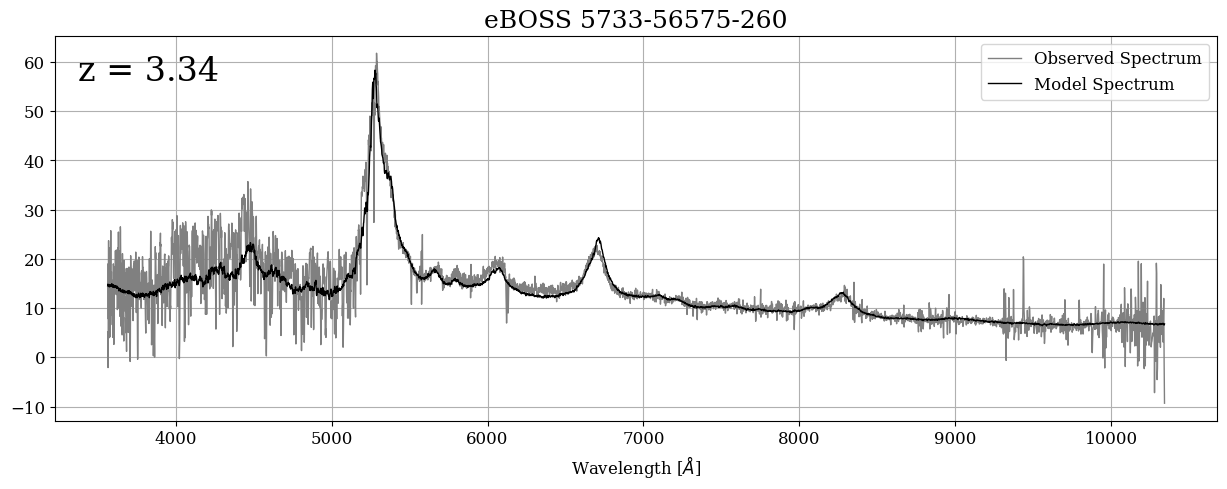

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))

# Define wavelengths
# eBOSS wavelengths are in log space - convert to linear
wls = 10**eboss_spectrum[1].data['loglam']

# Get the observed and model flux from extension 1
observed_flux = eboss_spectrum[1].data['flux']
model_flux = eboss_spectrum[1].data['model']

# Plot the observed spectrum
plt.plot(wls, observed_flux, c='gray', label='Observed Spectrum')
# Plot the model spectrum
plt.plot(wls, model_flux, c='k', label='Model Spectrum')

# Set title and labels
plt.title(f"{eboss_obs_list['target_name'][0]}")
redshift = eboss_spectrum[2].data['Z'][0] # redshift from SPALL table
plt.text(0.02, 0.95, f"z = {str(round(redshift, 2))}", 
         fontsize=24, ha='left', va='top', transform=ax.transAxes)
plt.xlabel(r'Wavelength [$\AA$]')
plt.grid() # Add grid lines
plt.legend(loc='upper right') # Add plot legend
plt.show() # Display plot

The eBOSS spectrum for this QSO looks great! The large spikes around 5200, 6700, and 8200 angstroms are strong emission lines from the accretion disk around the supermassive black hole in the center of this QSO. We can identify which emission lines they are by using the quasar's redshift, which we will do next.


## Identifying Emission Lines in a QSO Spectrum

Let's spruce up this plot by adding labels on the emission lines, and plotting a second panel which shows the brightness (flux) as color instead of a line.

To help with identifying the emision lines, let's write a helper function to define and plot the emission lines we want to label, called `plot_emission_lines()`. Becasue this quasar is so far away, the emission lines will be redshifted, meaning the observed wavelength might be far away from the rest wavelength!

The equation for calculating the observed wavelength of an emission line at redshift $z$ is:

\begin{equation}
1+z = \frac{\lambda_{observed}}{\lambda_{emitted}}
\end{equation}

where $\lambda_{emitted}$ is the rest-frame wavelength of the emission line, and  $z$ is the redshift. We will use this equation to convert between rest wavelength and observed wavelength in our helper function.

In [9]:
# Create a dictionary of emission lines we want to label
# These line definitions are from the eBOSS pipeline: https://data.sdss.org/datamodel/files/SPECTRO_REDUX/RUN2D/PLATE4/spZline.html
emission_line_list = [
    {
        'emline': r'Lyman-$\alpha$',
        'rest_wavelength': 1215.67,
        'label_color': 'purple',
        'label_index': 16,
        'label_angle': 35,
    },
    {
        'emline': 'C IV',
        'rest_wavelength': 1549.487,
        'label_color': 'mediumblue',
        'label_index': 14,
        'label_angle': 35,
    },
    {
        'emline': '[C III]',
        'rest_wavelength': 1908.734,
        'label_color': 'deepskyblue',
        'label_index': 12,
        'label_angle': 25,
    },
    {
        'emline': 'Mg II',
        'rest_wavelength': 2800.31518862,
        'label_color': 'green',
        'label_index': 8,
        'label_angle': 20,
    },
    {
        'emline': '[O III]',
        'rest_wavelength': 5008.23966962,
        'label_color': 'darkorange',
        'label_index': 2,
        'label_angle': 10,
    },
    {
        'emline': r'H-$\alpha$',
        'rest_wavelength': 6564.61397371,
        'label_color': 'red',
        'label_index': 1,
        'label_angle': 10,
        }
    ]


def plot_emission_lines(ax: plt.axes, redshift: float) -> None:
    """
    Helper function to plot emission line references on a figure.

    Parameters:
    ============
    ax: 
        The axes object to draw on
    redshift:
        the redshift (z) of the QSO which determines how much to shift the lines
        from the rest wavelength to the observed wavelength.
    """    
    # Plot and Label the emission lines
    for emline in emission_line_list:
        # Calculate observed wavelength from quasar redshift
        observed_wavelength = (1+redshift)*emline['rest_wavelength']
        # If the observed wavelength is within the limits of the plot, plot it!
        if (observed_wavelength >= np.min(wls)) & (observed_wavelength <= np.max(wls)):
            ax.axvline(observed_wavelength, c=emline['label_color'], linestyle='--', lw=2)
            ax.axvline(observed_wavelength, c=emline['label_color'], linestyle='--', lw=2)
            ax.text(observed_wavelength, 0.98, emline['emline'],
                    color=emline['label_color'], rotation=90, ha='right', va='top', fontsize=16,
                    transform=ax.get_xaxis_transform())

In the next cell, we plot the spectrum again adding these new features.

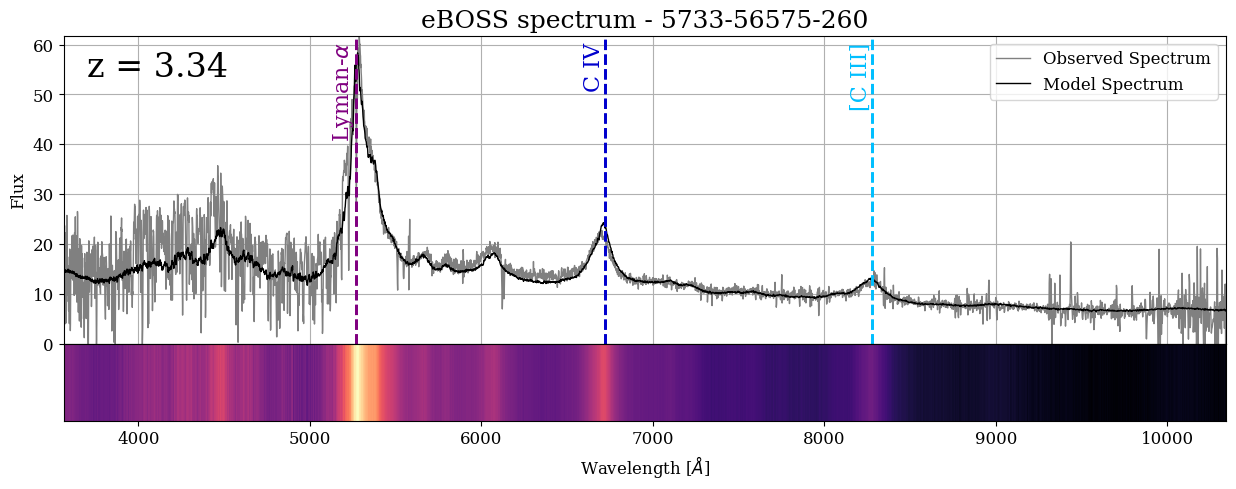

In [10]:
# Set up spectrum plot
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot2grid((5, 1), (0, 0), colspan=1, rowspan=4)
ax2 = plt.subplot2grid((5, 1), (4, 0), colspan=1, rowspan=1)

# Open spectrum file
eboss_spectrum = fits.open(manifest['Local Path'][0])
# Define QSO name
eboss_id = f"{eboss_spectrum[0].header['PLATEID']}-{eboss_spectrum[0].header['MJD']}-{eboss_spectrum[0].header['FIBERID']}"
# Retrieve redshift from SPALL table
redshift = eboss_spectrum[2].data['Z'][0] 

# Define wavelengths
wls = 10**eboss_spectrum[1].data['loglam']
# Get the observed and model flux from extension 1
observed_flux = eboss_spectrum[1].data['flux']
model_flux = eboss_spectrum[1].data['model']


# Plot the observed spectrum
ax1.plot(wls, observed_flux, c='gray', label='Observed Spectrum')
# Plot the model spectrum
ax1.plot(wls, model_flux, c='k', label='Model Spectrum')
# Normalize the flux for the colobar
normalized_flux = (model_flux/np.max(model_flux))
ax2.pcolormesh(wls, [0, 1], [normalized_flux, normalized_flux],
               norm=LogNorm(), cmap='magma')

# Plot emission lines
plot_emission_lines(ax1, redshift)

# Set title and labels
ax1.set_title(f"eBOSS spectrum - {eboss_id}")
# Add redshift to plot
ax1.text(0.02, 0.95, f"z = {str(round(redshift, 2))}", 
         fontsize=24, ha='left', va='top', transform=ax1.transAxes)
ax2.set_xlabel(r'Wavelength [$\AA$]')
ax2.set_yticks([])
ax1.set_ylabel('Flux')
ax1.grid() # Add grid lines
ax1.legend(loc='upper right') # Add plot legend
# Set axes limits
ax1.set_xlim(np.min(wls), np.max(wls))
ax2.set_xlim(np.min(wls), np.max(wls))
ax1.set_ylim(0, np.max(observed_flux))
plt.subplots_adjust(hspace=0) # remove space between plots

plt.show() # Display Plot

The top panel of our figure shows the spectrum as a line plot, where the bottom panel shows it as a color plot. The higher the flux is in the top panel, the brighter yellow color it is in the bottom panel: two different ways of looking at the same spectrum. With this plot, we can see that the three brightest emission lines in this QSO are Lyman-$\alpha$, C IV and [C III]! 

## Exploring QSO spectra at different redshift

Now that we've demonstrated how to search, download, and plot a quasar spectrum from eBOSS, let's repeat this process and look at several QSOs across cosmic time. Our goal is to explore how different characteristics of quasar spectra evolve over time, from the closest to us (low redshift) to farthest away (high redshift).

Here is a list of eBOSS QSOs from a sampling of different redshifts curated for this exercise:

In [11]:
eboss_qso_list = [
    'sdss_eboss_12547-58928-0063', # redshift z = 0.25
    'sdss_eboss_12547-58928-0268', # redshift z = 0.49
    'sdss_eboss_3846-55327-0212', # z = 0.71
    'sdss_eboss_12547-58928-0707', # z = 1.0
    'sdss_eboss_12547-58928-0771', # z = 1.23
    'sdss_eboss_12547-58928-0178', # z = 1.49
    'sdss_eboss_12547-58928-0349', # z =  1.75
    'sdss_eboss_12547-58928-0029', # z = 2.04
    'sdss_eboss_3586-55181-0080', # z = 2.25
    'sdss_eboss_3586-55181-0162', # z = 2.48
    'sdss_eboss_3586-55181-0516', # z = 2.75
    'sdss_eboss_12547-58928-0478', # z = 2.97
    'sdss_eboss_3788-55246-0056', # z = 3.26
    'sdss_eboss_3846-55327-0080', # z =  3.49
    'sdss_eboss_12547-58928-0484', # z = 3.73
    'sdss_eboss_10737-58254-0984', # z = 3.99
    'sdss_eboss_7238-56660-0542', # z = 4.27
    'sdss_eboss_8789-57358-0092', # z = 4.5 
    'sdss_eboss_3588-55184-0548', # z = 4.71
    'sdss_eboss_8528-57896-0104', # z = 5.00
    'sdss_eboss_10256-58193-0330', # z = 5.26
    'sdss_eboss_6782-56602-0526', # z = 5.48
    'sdss_eboss_11315-58402-0842', # z = 5.76
    'sdss_eboss_6667-56412-0676', # z = 6
]

For each of these quasars, we will download the spectra using `astroquery.mast` and plot them as a color plot like we did before. Only this time, we are going to plot them all on the same figure to see how quasar spectra change over redshift!

In [12]:
def get_eboss_qso_spectrum(eboss_obs_id: str):
    """
    Given an eBOSS observation ID, query MAST and download the spectrum using astroquery.mast

    Parameters:
    =============
    eboss_obs_id: str
        Name of the target / observation ID to search on.

    Returns:
    =============
    dictionary of...    
    """
    # Query MAST for eBOSS observation
    obs_list = Observations.query_criteria(provenance_name='eBOSS', # Query eBOSS data
                                           obs_id=eboss_obs_id) # Search for a specific target
    
    # Retrieve products
    products = Observations.get_product_list(obs_list)
    # Download spectrum file
    manifest = Observations.download_products(products, mrp_only=True)

    eboss_spectrum = fits.open(manifest['Local Path'][0])
    z = eboss_spectrum[2].data['Z'][0] # redshift from SPALL table
    wls = 10**eboss_spectrum[1].data['loglam']
    model_flux = eboss_spectrum[1].data['model']
    normalized_flux = model_flux/np.max(model_flux)
    
    # Define a dictionary with the spectrum and other information we want to save
    qso_spec = {
        "name":  f"eBOSS {eboss_obs_id.split('_')[-1]}",
        "spectrum_filename": manifest['Local Path'],
        "redshift": z,
        "wls": wls,
        "flux": normalized_flux,
        }

    return qso_spec    


all_qsos = [get_eboss_qso_spectrum(obs_id) for obs_id in eboss_qso_list]

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


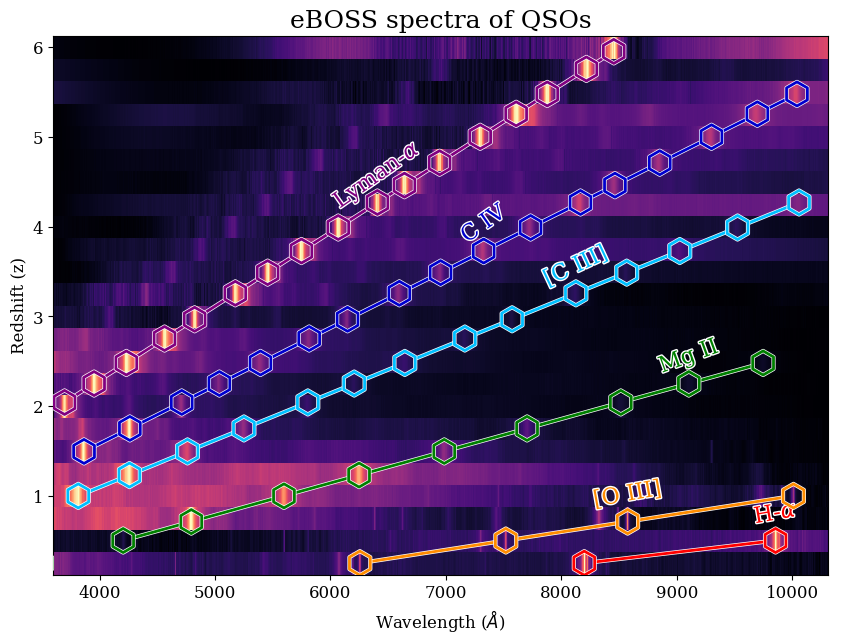

In [13]:
fig = plt.figure(figsize=(10, 7))
ax = plt.subplot2grid((1, 1), (0, 0))

for qso in all_qsos:
    # Round to nearest 0.25 in redshift just to align things on a grid
    nearest_redshift = round(qso['redshift']*4)/4
    plt.pcolormesh(qso['wls'], [nearest_redshift-0.065, nearest_redshift+0.065],
                   [qso['flux'], qso['flux']], cmap='magma')

# Label emission lines
for i, emline in enumerate(emission_line_list):
    # Outline the emission lines
    all_redshifts = np.array([qso['redshift'] for qso in all_qsos])
    wavelength_obs = (1+all_redshifts)*emline['rest_wavelength']
    points = plt.scatter(wavelength_obs, all_redshifts,
                         lw=2, edgecolor=emline['label_color'],
                         marker='h', s=300, facecolor='None', zorder=10)
    points.set_path_effects([path_effects.withStroke(linewidth=3, foreground='w')])
    
    # Add connecting lines
    for i in range(len(wavelength_obs)-1):
        if (wavelength_obs[i] <= 9800) & ((wavelength_obs[i] >= 3590)):
            cp = ConnectionPatch((wavelength_obs[i], all_redshifts[i]), (wavelength_obs[i+1], all_redshifts[i+1]), 
                                 coordsA='data', coordsB='data', axesA=ax, axesB=ax,
                                 color=emline['label_color'],
                                 shrinkA=np.sqrt(300)/2, shrinkB=np.sqrt(300)/2,
                                 linewidth=2, zorder=1)
            cp.set_path_effects([path_effects.withStroke(linewidth=3, foreground='w')])
            ax.add_patch(cp)

    # Add text for line labels
    text = plt.text(wavelength_obs[emline['label_index']], all_redshifts[emline['label_index']]+0.3, emline['emline'],
                    c=emline['label_color'], ha='center', va='center', fontsize=16, rotation=emline['label_angle'])
    # Add white border for readability
    text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='w')])


plt.xlim(3596, 10310)
plt.ylabel('Redshift (z)')
plt.xlabel(r'Wavelength ($\AA$)')
plt.title('eBOSS spectra of QSOs')

plt.show()

This plot shows 24 different eBOSS spectra in one figure, going from low-reshift (z=0.25) to high-redshift (z=6)! The emission lines are visible in every spectrum, and this figure shows how distance shifts the emissions lines into longer and longer wavelengths! Studying quasars has a broad range of use in astronomical research: because quasars are so luminous, they can be observed at very high redshift and can give scientists insight into distant reaches of the Universe.

***
# Searching for High-Redshift JWST spectra

The quasar plot we made with eBOSS spectra is great, but let's push our quasar sample into even higher redshift quasars by using JWST. JWST is an infrared telescope which observes in longer wavelengths than eBOSS (although there is some overlap between them), making it perfect for observing extremely high redshift galaxies.

Here is a list of three high-redshift QSOs that have been observed with the NIRSPEC instrument, as part of [JWST Program GO 1222](https://www.stsci.edu/jwst-program-info/program/?program=1222):
- VDES J0020–3653 (z = 6.860)
- DELS J0411–0907 (z = 6.825)
- UHS J0439+1634 (z = 6.519)

Let's add these galaxies to our eBOSS plot, to extend our sample to even higher redshift!

In [14]:
# Search for JWST data
jwst_obs_list = Observations.query_criteria(obs_collection='JWST', # Search for JWST data
                                            proposal_id='1222', # Search based on program ID
                                            dataproduct_type='spectrum', # Limit search to spectra
                                            )

# Print lenght of results
print(f"Found {len(jwst_obs_list)} results!")

# Display first 5 results
jwst_obs_list[:5]

Found 238 results!


intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str7,str12,str4,str12,str8,str26,str39,str58,float64,float64,str8,str17,int64,float64,float64,float64,float64,float64,str80,float64,str4,str3,int64,str111,str84,str85,str6,bool,float64,str9,str9
science,JWST,CALJWST,NIRSPEC/SLIT,JWST,F170LP;G235H,INFRARED,UHSJ0439+1634,Galaxy; High-redshift galaxies; Quasars,jw01222-o011_s000000001_nirspec_f170lp-g235h-s200a1,69.94621666666667,16.571033333333332,spectrum,"Willott, Chris J.",3,59968.23952821759,59968.31842642361,2844.834,1660.0,5000.0,"Cosmic reionization, metal enrichment and host galaxies from quasar spectroscopy",60333.76431704,1222,GTO,--,POLYGON 69.945797828 16.571689339 69.946628685 16.571689339 69.946628685 16.570355748 69.945797828 16.570355748,mast:JWST/product/jw01222-o011_s000000001_nirspec_f170lp-g235h-s200a1_cal.jpg,mast:JWST/product/jw01222-o011_s000000001_nirspec_f170lp-g235h-s200a1_s2d.fits,PUBLIC,False,nan,232625998,844731103
science,JWST,CALJWST,NIRSPEC/SLIT,JWST,F070LP;G140H,INFRARED,UHSJ0439+1634,Galaxy; High-redshift galaxies; Quasars,jw01222-o011_s000000012_nirspec_f070lp-g140h-s200a2,69.94621666666667,16.571033333333332,spectrum,"Willott, Chris J.",3,59968.23952821759,59968.27992793982,2844.834,700.0,5000.0,"Cosmic reionization, metal enrichment and host galaxies from quasar spectroscopy",60333.76431704,1222,GTO,--,POLYGON 69.941442355 16.575358927 69.942289416 16.575358927 69.942289416 16.574003292 69.941442355 16.574003292,mast:JWST/product/jw01222-o011_s000000012_nirspec_f070lp-g140h-s200a2_cal.jpg,mast:JWST/product/jw01222-o011_s000000012_nirspec_f070lp-g140h-s200a2_s2d.fits,PUBLIC,False,nan,232629349,844731131
science,JWST,CALJWST,NIRSPEC/SLIT,JWST,F170LP;G235H,INFRARED,UHSJ0439+1634,Galaxy; High-redshift galaxies; Quasars,jw01222-o011_s000000015_nirspec_f170lp-g235h-s200b1,69.94621666666667,16.571033333333332,spectrum,"Willott, Chris J.",3,59968.23952821759,59968.31842642361,2844.834,1660.0,5000.0,"Cosmic reionization, metal enrichment and host galaxies from quasar spectroscopy",60333.69175919,1222,GTO,--,POLYGON 69.987084496 16.552858901 69.98791359 16.552858901 69.98791359 16.551496306 69.987084496 16.551496306,mast:JWST/product/jw01222-o011_s000000015_nirspec_f170lp-g235h-s200b1_cal.jpg,mast:JWST/product/jw01222-o011_s000000015_nirspec_f170lp-g235h-s200b1_s2d.fits,PUBLIC,False,nan,232629350,844731141
science,JWST,CALJWST,NIRSPEC/SLIT,JWST,F070LP;G140H,INFRARED,UHSJ0439+1634,Galaxy; High-redshift galaxies; Quasars,jw01222-o011_s000000001_nirspec_f070lp-g140h-s200a1,69.94621666666667,16.571033333333332,spectrum,"Willott, Chris J.",3,59968.23952821759,59968.27992793982,2844.834,700.0,5000.0,"Cosmic reionization, metal enrichment and host galaxies from quasar spectroscopy",60333.76431704,1222,GTO,--,POLYGON 69.945798319 16.571686993 69.946628519 16.571686993 69.946628519 16.570354577 69.945798319 16.570354577,mast:JWST/product/jw01222-o011_s000000001_nirspec_f070lp-g140h-s200a1_cal.jpg,mast:JWST/product/jw01222-o011_s000000001_nirspec_f070lp-g140h-s200a1_s2d.fits,PUBLIC,False,nan,232625999,844731161
science,JWST,CALJWST,NIRSPEC/SLIT,JWST,F170LP;G235H,INFRARED,UHSJ0439+1634,Galaxy; High-redshift galaxies; Quasars,jw01222-o011_s000000013_nirspec_f170lp-g235h-s400a1,69.94621666666667,16.571033333333332,spectrum,"Willott, Chris J.",3,59968.23952821759,59968.31842642361,2844.834,1660.0,5000.0,"Cosmic reionization, metal enrichment and host galaxies from quasar spectroscopy",60333.69175919,1222,GTO,--,POLYGON 69.945200123 16.574577994 69.946108378 16.574577994 69.946108378 16.573121456 69.945200123 16.573121456,mast:JWST/product/jw01222-o011_s000000013_nirspec_f170lp-g235h-s400a1_cal.jpg,mast:JWST/produc

There are a lot of results (over 200!), so for convenience here, let's just use two files per galaxy, curated in this list below:

In [15]:
# Define a list of JWST spectra to add to our plot
jwst_spectra = [
    {"name": "VDES J0020-3653",
     "proposal_id": 1222,
     "redshift": 6.860,
     "obs1": "jw01222-o012_s000000001_nirspec_f170lp-g235h-s200a2-s200a1",
     "obs2": "jw01222-o012_s000000001_nirspec_f070lp-g140h-s200a1-s200a2"},

    {"name": "DELS J0411-0907",
     "proposal_id": 1222,
     "redshift": 6.825,
     "obs1": "jw01222-o002_s000000001_nirspec_f170lp-g235h-s200a2-s200a1",
     "obs2": "jw01222-o002_s000000001_nirspec_f070lp-g140h-s200a1-s200a2",
     },

    {"name": "UHS J0439+1634",
     "proposal_id": 1222,
     "redshift": 6.519,
     "obs1": "jw01222-o011_s000000001_nirspec_f170lp-g235h-s200a1",
     "obs2": "jw01222-o011_s000000001_nirspec_f070lp-g140h-s200a1",
     },
]

For each of these three galaxies, we will download the JWST spectra and store them in a small dictonary, just like we did for eBOSS.

In [16]:
def get_jwst_qso_spectrum(jwst_spec_dict):
    """
    Given an JWST observation ID, query MAST and download the spectrum using astroquery.mast

    Parameters:
    =============
    jwst_spec_data: dict
        Dictionary of object name and observation ids for retreieving the JWST spectra

    Returns:
    =============
    dictionary of...
    """

    z = jwst_spec_dict['redshift']

    # Query MAST for JWST observation
    obs_list = Observations.query_criteria(obs_collection='JWST', # Search for JWST data
                                           obs_id=jwst_spec_dict['obs1'], # Search on obs_id
                                           )
    # Retrieve products
    products_list = Observations.get_product_list(obs_list)
    # Filter products to just extracted 1D spectra
    products_list = Observations.filter_products(products_list, productType='SCIENCE',
                                                 productSubGroupDescription='ANNNN_X1D',
                                                 mrp_only=True)
    # Download spectrum file
    jwst_manifest = Observations.download_products(products_list)
    # Open file
    jwst_spec = fits.open(jwst_manifest['Local Path'][0])
    # Retrieve wavelength and flux from the file
    wls = jwst_spec['EXTRACT1D'].data['WAVELENGTH']*10000 # convert microns to Angstroms
    observed_flux = jwst_spec['EXTRACT1D'].data['FLUX']
    # Normalize the Flux values based on some percentile values
    min_flux = np.nanpercentile(observed_flux, 5) # 5th percentile
    max_flux = np.nanpercentile(observed_flux, 99.5) # 99th percentile
    normalized_flux = (observed_flux-min_flux)/(max_flux-min_flux)

    # Do it again for the second obs
    obs_list = Observations.query_criteria(obs_collection='JWST', # Search for JWST data
                                           obs_id=jwst_spec_dict['obs2']) # Search on obs_id
    # Retrieve products
    products_list = Observations.get_product_list(obs_list)
    # Filter products to just extracted 1D spectra
    products_list = Observations.filter_products(products_list, productType='SCIENCE',
                                                 productSubGroupDescription='ANNNN_X1D',
                                                 mrp_only=True)
    # Download spectrum file
    jwst_manifest = Observations.download_products(products_list)
    # Open file
    jwst_spec = fits.open(jwst_manifest['Local Path'][0])
    # Retrieve wavelength and flux from the file
    wls = np.append(wls, jwst_spec['EXTRACT1D'].data['WAVELENGTH']*10000) # convert microns to Angstroms
    observed_flux = jwst_spec['EXTRACT1D'].data['FLUX']
    # Normalize the Flux values based on some percentile values
    min_flux = np.nanpercentile(observed_flux, 30) # 30th percentile
    max_flux = np.nanpercentile(observed_flux, 99.5) # 99th percentile
    normalized_flux = np.append(normalized_flux, (observed_flux-min_flux)/(max_flux-min_flux))

    # Define a dictionary with the spectrum and other information we want to save
    qso_spec = {
        "name": jwst_spec_dict['name'],
        "redshift": z,
        "wls": wls[np.argsort(wls)],
        "flux": normalized_flux[np.argsort(wls)],
        }

    return qso_spec   


jwst_qsos = [get_jwst_qso_spectrum(j) for j in jwst_spectra]

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Let's plot one of these, like we did before, to see what it looks like:

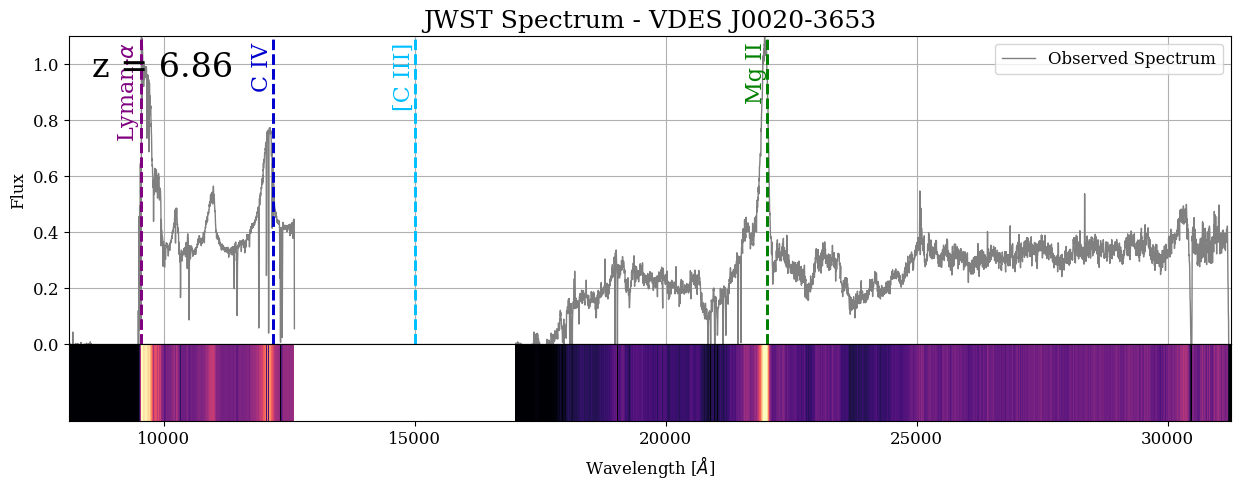

In [17]:
# Set up spectrum plot
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot2grid((5, 1), (0, 0), colspan=1, rowspan=4)
ax2 = plt.subplot2grid((5, 1), (4, 0), colspan=1, rowspan=1)

qso = jwst_qsos[0]

redshift = qso['redshift']
# Plot the observed spectrum
wls = qso['wls']
flux = qso['flux']
ax1.plot(wls, flux, c='gray', label='Observed Spectrum')

ax2.pcolormesh(wls, [0, 1], [flux, flux],
               cmap='magma', vmin=0, vmax=1)

# Plot emission lines
plot_emission_lines(ax1, redshift)

# Set title and labels
ax1.set_title(f"JWST Spectrum - {qso['name']}")
# Add redshift to plot
ax1.text(0.02, 0.95, f"z = {str(round(redshift, 2))}", 
         fontsize=24, ha='left', va='top', transform=ax1.transAxes)
ax2.set_xlabel(r'Wavelength [$\AA$]')
ax2.set_yticks([])
ax1.set_ylabel('Flux')
ax1.grid() # Add grid lines
ax1.legend(loc='upper right') # Add plot legend
# Set axes limits
ax1.set_xlim(np.min(qso['wls']), np.max(qso['wls']))
ax2.set_xlim(np.min(qso['wls']), np.max(qso['wls']))
ax1.set_ylim(0, 1.1)
plt.subplots_adjust(hspace=0) # remove space between plots

plt.show() # Display Plot

Notice how this NIRSPEC spectrum covers a much different wavelength range than eBOSS. eBOSS spectra fall between 3,000 and 10,000 angstroms in visible light. JWST observed between 7,000 and 30,000 Angstroms! The JWST spectrum still has the same strong emission lines (Lyman-$\alpha$, C-IV and Mg II) that we saw before in the lower-redshift eBOSS quasars, only in infrared wavelengths because this quasar is so far away.

## Combining eBOSS and JWST Data

Now we can recreate our plot from before, adding these JWST spectra as very-high-redshift examples!

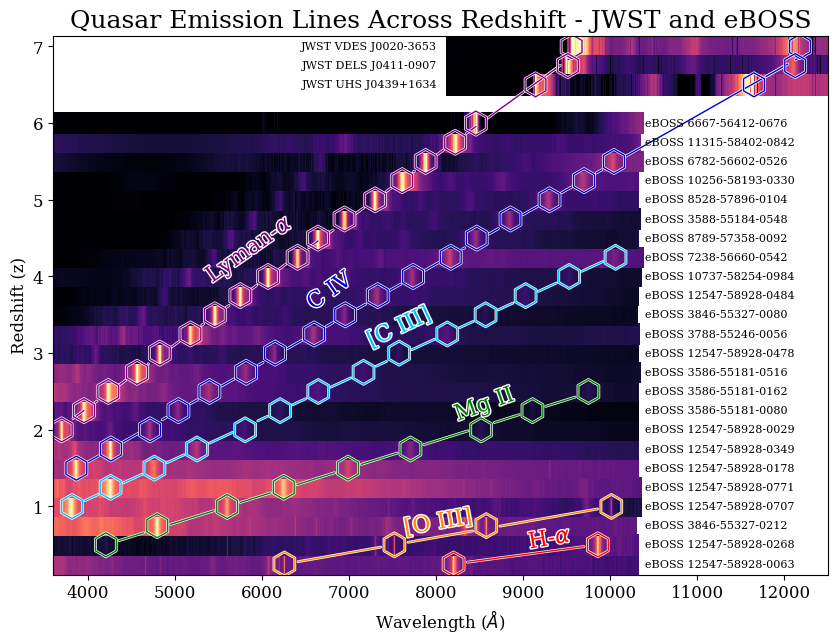

In [18]:
fig = plt.figure(figsize=(10, 7))
ax = plt.subplot2grid((1, 1), (0, 0))

for qso in jwst_qsos:
    # Round to nearest 0.25 in redshift just to align things on a grid
    nearest_redshift = round(qso['redshift']*4+0.1)/4
    plt.pcolormesh(qso['wls'], [nearest_redshift-0.07, nearest_redshift+0.07],
                   [qso['flux'], qso['flux']], cmap='magma', vmin=0, vmax=1)
    plt.text(np.min(qso['wls']-100), nearest_redshift, f"JWST {qso['name']}", va='center', ha='right', fontsize=8)


for qso in all_qsos:
    # Round to nearest 0.25 in redshift just to align things on a grid
    nearest_redshift = round(qso['redshift']*4)/4
    plt.pcolormesh(qso['wls'], [nearest_redshift-0.07, nearest_redshift+0.07],
                   [qso['flux'], qso['flux']], cmap='magma', vmin=0, vmax=1)
    plt.text(10400, nearest_redshift, qso["name"], va='center', ha='left', fontsize=8)

all_redshifts = np.array([qso['redshift'] for qso in all_qsos+jwst_qsos])
wl_limits = np.array([np.max(qso['wls']) for qso in all_qsos+jwst_qsos])
wl_limits[wl_limits > 12500] = 12500

# Label and annotate emission lines
for i, emline in enumerate(emission_line_list):
    # Calculate observed wavelength for redshift
    wavelength_obs = (1+all_redshifts)*emline['rest_wavelength']
    # Limit the points to those within the wavelength range of each spectrum
    point_mask = (wavelength_obs <= wl_limits) & (wavelength_obs >= 3500)
    # Plot the points
    points = plt.scatter(wavelength_obs[point_mask], [round(z*4+0.1)/4 for z in all_redshifts[point_mask]],
                         lw=1, edgecolor=emline['label_color'],
                         marker='h', s=300, facecolor='None', zorder=2)
    points.set_path_effects([path_effects.withStroke(linewidth=2, foreground='w')])
    # Add connecting lines between the points
    for i in range(len(wavelength_obs[point_mask])-1):
        cp = ConnectionPatch((wavelength_obs[point_mask][i], all_redshifts[point_mask][i]),
                             (wavelength_obs[point_mask][i+1], all_redshifts[point_mask][i+1]), 
                             coordsA='data', coordsB='data', axesA=ax, axesB=ax,
                             color=emline['label_color'], shrinkA=10, shrinkB=10,
                             linewidth=1, zorder=1)
        cp.set_path_effects([path_effects.withStroke(linewidth=2, foreground='w')])
        ax.add_patch(cp)

    # Add text for line labels
    text_coord_x = wavelength_obs[emline['label_index']]-550
    text_coord_y = all_redshifts[emline['label_index']]+0.075
    text = plt.text(text_coord_x, text_coord_y, emline['emline'],
                    c=emline['label_color'], ha='center', va='center',
                    fontsize=16, rotation=emline['label_angle'])
    # Add white border for readability
    text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='w')])

#plt.xlim(3596, 24000)
plt.xlim(3596, 12500)
plt.ylabel('Redshift (z)')
plt.xlabel(r'Wavelength ($\AA$)')
plt.title('Quasar Emission Lines Across Redshift - JWST and eBOSS')

plt.show()

***
Congratulations! You have reached the end of this tutorial notebook. You have learned how to access and download eBOSS data from MAST, and combine it with NIRSPEC observations to characterize quasar spectra across cosmic time.

# Additional Resources

Additional resources are linked below:

- [SDSS Legacy Archive at MAST](https://archive.stsci.edu/missions-and-data/sdss)
- [SDSS Legacy Archive at MAST User Manual](https://outerspace.stsci.edu/display/SDSS/The+SDSS+Legacy+Archive+at+MAST)
- [SDSS-IV eBOSS Survey](https://www.sdss4.org/surveys/eboss/)
- [astroquery.mast User Manual](https://astroquery.readthedocs.io/en/latest/mast/mast.html)
- [MAST API](https://mast.stsci.edu/api/v0/index.html)


## Citations

If you use eBOSS data for published research, see the following links for information on which citations to include in your paper:

* [Citing SDSS](https://sdss.org/collaboration/citing-sdss/)
* [Citing MAST](https://archive.stsci.edu/publishing/mission-acknowledgements)
* [Citing astropy](https://www.astropy.org/acknowledging.html)


## About this Notebook

**Author(s):** Julie Imig (jimig@stsci.edu) <br>
**Keyword(s):** Tutorial, SDSS, eBOSS, JWST, QSO, quasar <br>
**First published:** March 2025 <br>
**Last updated:** March 2025 <br>

***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/style-guides/master/guides/images/stsci-logo.png" alt="Space Telescope Logo" width="200px"/> 